In [42]:
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%pylab inline
pylab.rcParams['figure.figsize'] = (24, 12)
import numpy as np
import pandas as pd
from scipy import stats
import json
import os
from stldecompose import decompose, forecast
from statsmodels.tsa.seasonal import seasonal_decompose
from elasticsearch import Elasticsearch
import datetime
import ciso8601

import importlib
detector = importlib.import_module('thermometr')

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.5/dist-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['det']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [43]:
client = Elasticsearch()
query_total_bucket = {
  "aggs": {
    "my_aggregation": {
      "date_histogram": {
        "field":     "@timestamp",
        "interval":  "30m"
      }
    }
  }
}

response = client.search(
    index="movi*",
    size=0,
    body=query_total_bucket)

print("Query time: ", response['took'])

#nota: hay que buscar la mejor manera de hacer esto porque parece rebuscado
dates = []
count = []
for element in response['aggregations']['my_aggregation']['buckets']:
    dates.append(pd.to_datetime(element['key_as_string']))
    count.append(element['doc_count'])
    
ts_resampled = pd.Series(count, index=dates)

Query time:  42


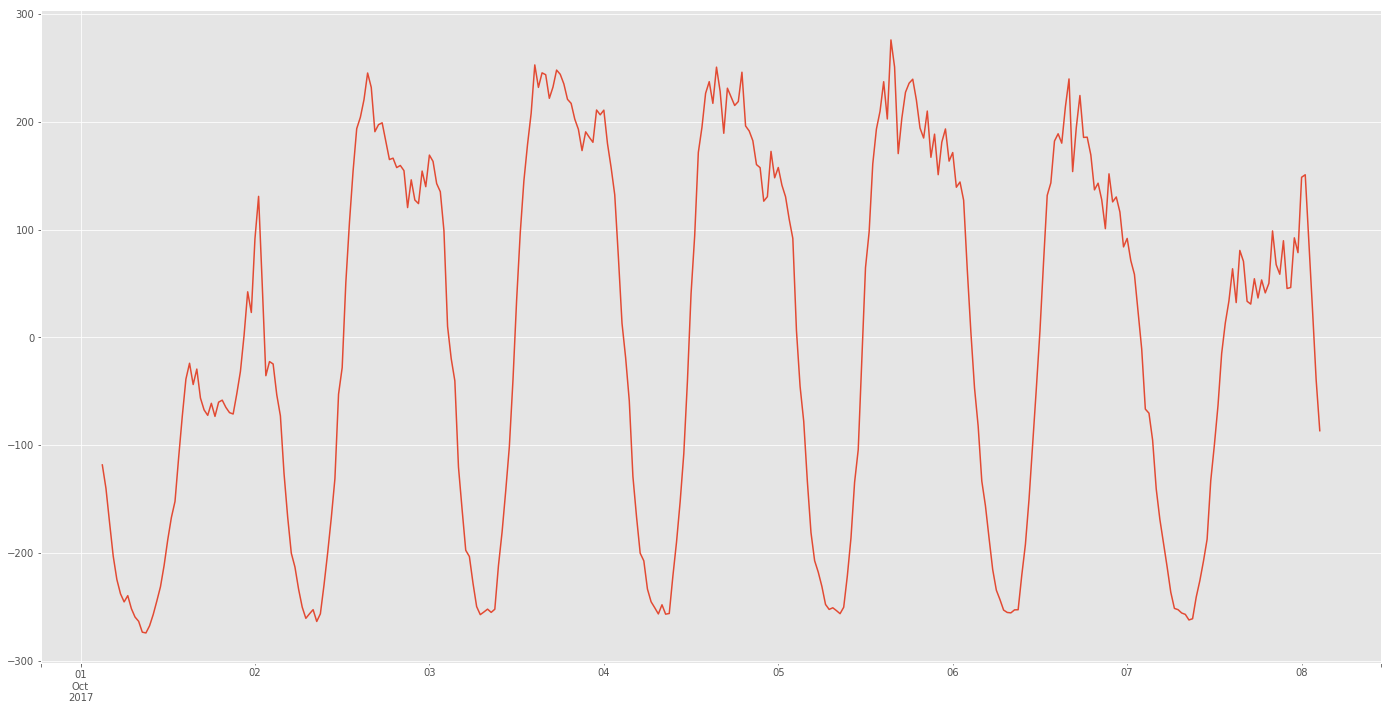

In [44]:
stl = decompose(ts_resampled, period=336)
stl.seasonal.head(336).plot();

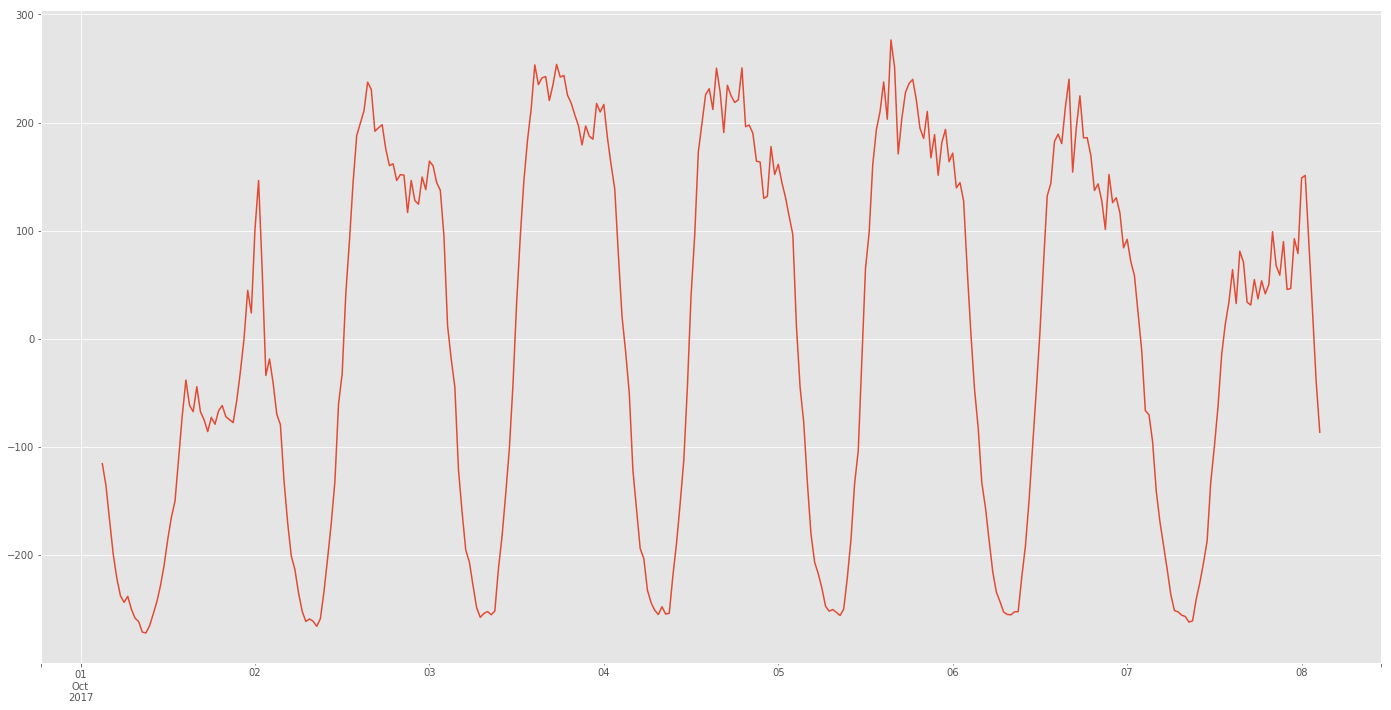

In [45]:
normaldecomp = seasonal_decompose(ts_resampled, freq=336)
normaldecomp.seasonal.head(336).plot();
                                  

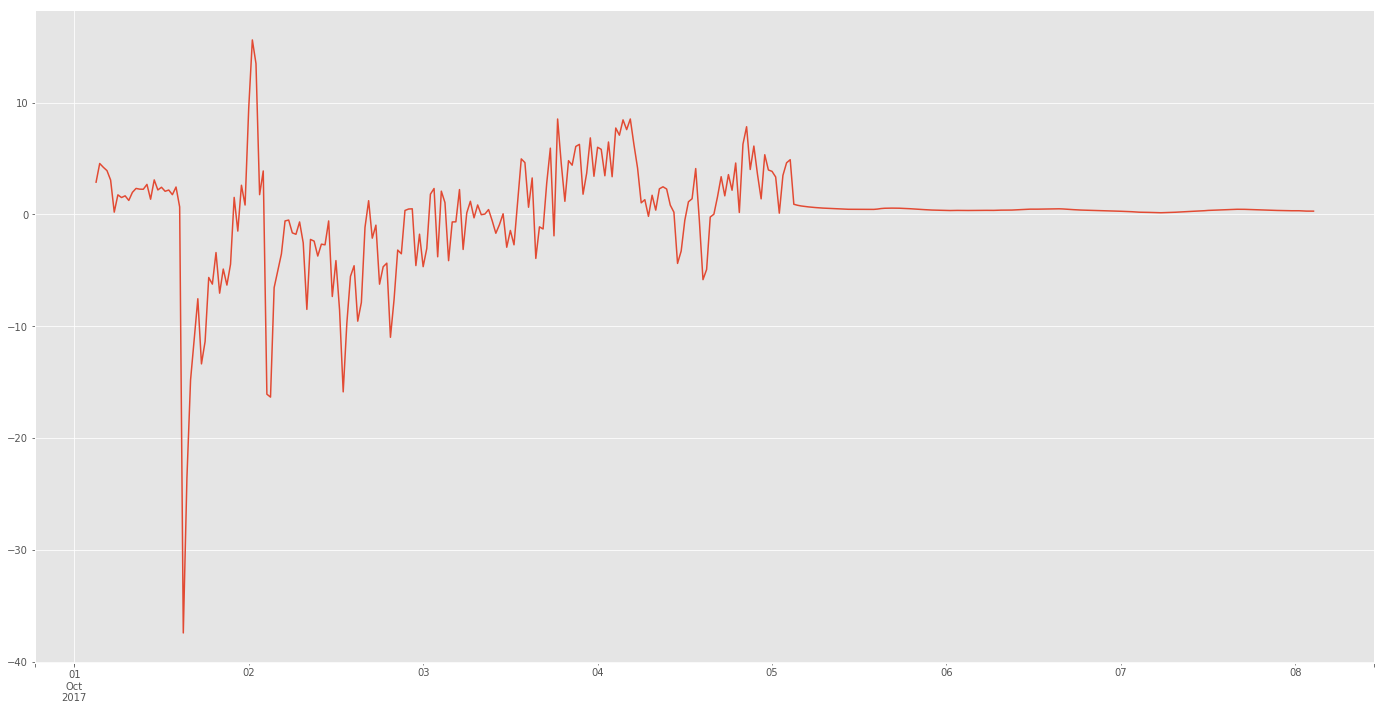

In [46]:
dif = normaldecomp.seasonal.head(336).sub(stl.seasonal.head(336))
dif.plot()

In [47]:
det = detector.Thermometr(ts_resampled)
res = det.detect()
print("\n Cantidad de anomalias: " + str(len(res)) + "\n" )
res


Start must be >= k_ar for conditional MLE or dynamic forecast. Got 12

 Cantidad de anomalias: 68



[{'ESD': 0.2915431963594223, 'index': 47, 'value': 668},
 {'ESD': 0.04492156825110816, 'index': 48, 'value': 580},
 {'ESD': 0.197333883304889, 'index': 182, 'value': 210},
 {'ESD': 0.25012787874917886, 'index': 236, 'value': 775},
 {'ESD': 0.009758375833254784, 'index': 995, 'value': 274},
 {'ESD': 0.2770860649085075, 'index': 997, 'value': 808},
 {'ESD': 0.05869113980835561, 'index': 1392, 'value': 565},
 {'ESD': 0.375670794614985, 'index': 1487, 'value': 971},
 {'ESD': 0.14315522005665893, 'index': 2014, 'value': 682},
 {'ESD': 0.020788888315213083, 'index': 2243, 'value': 753},
 {'ESD': 0.06600535093230486, 'index': 2477, 'value': 753},
 {'ESD': 0.24653843855698776, 'index': 2490, 'value': 896},
 {'ESD': 0.34130961373528546, 'index': 2536, 'value': 1080},
 {'ESD': 0.08137142054921909, 'index': 2538, 'value': 993},
 {'ESD': 0.12181884767841566, 'index': 2540, 'value': 562},
 {'ESD': 0.24258820302173234, 'index': 2542, 'value': 851},
 {'ESD': 0.20711081133695364, 'index': 2543, 'value

In [48]:
x, y = [], []
for dic_item in res:
    if dic_item['ESD'] > 0.05:
        x.append(dic_item['index'])
        y.append(dic_item['value'])
    
#plt.scatter(x,y, color='blue')
#plt.show()

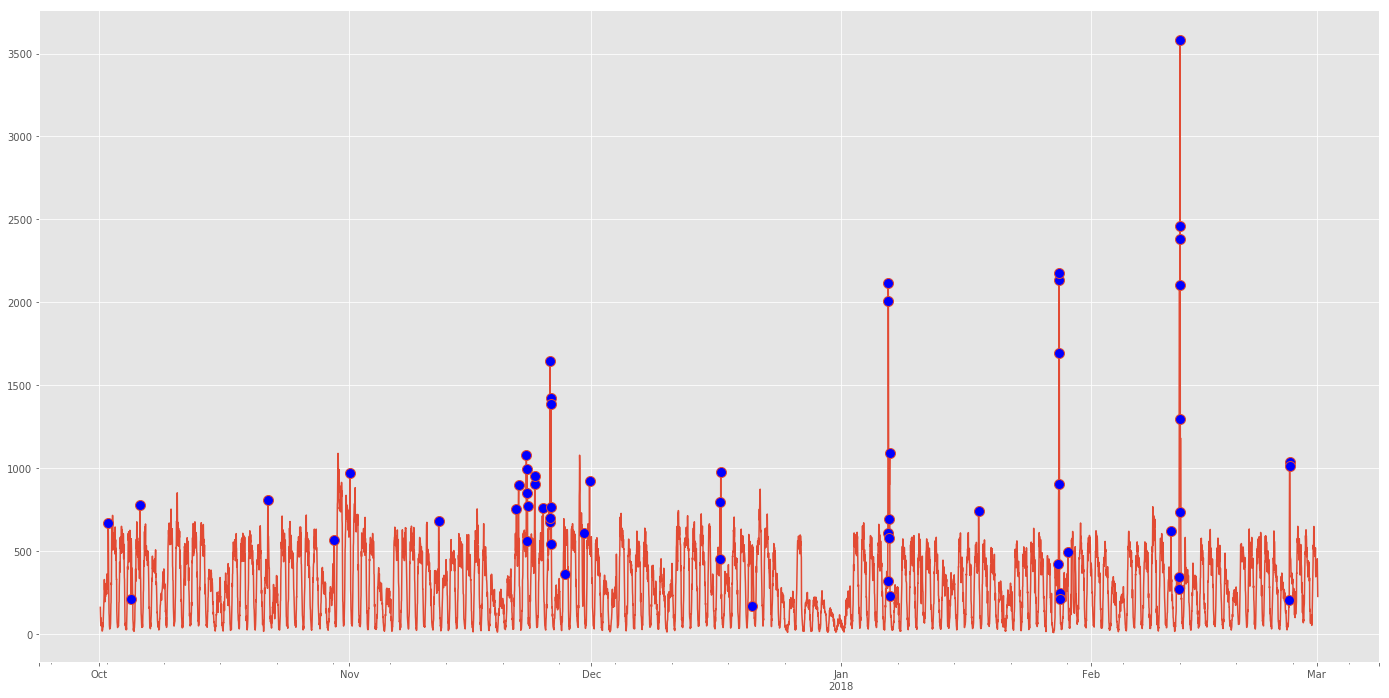

In [49]:
ts_resampled.plot(linestyle='-', markevery=x, marker='o', markersize=10, markerfacecolor='b')

In [60]:
for dic_item in res:
    print(ts_resampled.index[dic_item['index']].value // 10 ** 6)

1506911400000
1506913200000
1507154400000
1507251600000
1508617800000
1508621400000
1509332400000
1509503400000
1510452000000
1510864200000
1511285400000
1511308800000
1511391600000
1511395200000
1511398800000
1511402400000
1511404200000
1511476200000
1511479800000
1511481600000
1511573400000
1511641800000
1511645400000
1511649000000
1511650800000
1511652600000
1511654400000
1511656200000
1511805600000
1511962200000
1512007200000
1512068400000
1513465200000
1513470600000
1513474200000
1513805400000
1515263400000
1515265200000
1515268800000
1515270600000
1515274200000
1515276000000
1515285000000
1515288600000
1516237200000
1517092200000
1517095800000
1517097600000
1517099400000
1517101200000
1517104800000
1517106600000
1517193000000
1517232600000
1518300000000
1518382800000
1518384600000
1518390000000
1518391800000
1518393600000
1518395400000
1518397200000
1518399000000
1519144200000
1519565400000
1519569000000
1519570800000
1519871400000


In [51]:
type(res[0]['index'])

int